In [5]:
# Required packages to run the script
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticke
import seaborn as sns
from matplotlib.colors import LogNorm
import math
import os
import pickle as pkl
from scipy import sparse
from scipy.sparse.linalg import lsqr
import scipy.fftpack
import xlsxwriter
import importlib

# Importing homemade functions 
from import_excel import import_excel

from calc_translations import calculate_all_translations
from wavelet_decomposition import compute_wavelet_coefficient_betas
from wavelet_decomposition import preplotprocessing
from wavelet_decomposition import reconstruct

from plots import plot_betas_heatmap
from plots import plot_EPN
from calc_EPN import calc_epn
from plots import fft
from miscelaneous_functions import create_directory

In [6]:
# ---------------------------------
# ---------Defining the control parameters of the data to be analyzed
# ---------------------------------

#-------- Parameters of the wavelet decomposition -------------
#
vy = 6  # number of vectors per years (child wavelets)
vw = 3  # vectors per week
vd = 6  # vectors per day
#
# Time scales of the wavelet decomposition
# We define here the 15 time steps of the 'rich disctionnary' wavelets
time_scales = [0.75, 1.5, 3., 6., 12, 24., 42., 84., 168., 273.75, 547.5, 1095., 2190., 4380.,
              8760.] # cycles length, in hours

#-------- Parameters of the intput signals -------------
#
dpd = 24 # data per year
dpy = 365 # data per year :  cut the leap years to 365 years

# Signals can  be interpotated (within import_excel function)to a greater number of data per day (ndpd).This is useful for the wavelet decomposition to obtain daughter wavelets of th proper length.
ndpd = 64 # new data per year (for the interpolation). Minimum number so that the shortes wavelet has 2 data.
signal_length = ndpd * dpy


# ---------------------------------
# ---------Importing data
# ---------------------------------
# Directory path
path_input_data = 'input_time_series/Spain/'

# ---------Consumption
file_name = 'Espagne_load_entsoe_2021.xlsx'
conso_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True) # interpolate data from dpd to ndpd numper of points per day
# ---------PV
file_name = 'ES_pv_2016_osmose.xlsx'
PV_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True) # interpolate data from dpd to ndpd numper of points per day
# ---------Wind power
file_name = 'ES_wind_power_factor_2016_osmose.xlsx'
wind_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True) # interpolate data from dpd to ndpd numper of points per day



In [7]:
# ---------------------------------
# ---------Computing translations
# ---------------------------------
wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
input_data = conso_ts

# Check if the file exists
translation_name = 'Spain_2021'
translation_results_root = 'translation_calculation_results/' + translation_name 

path_trans = translation_results_root + '/translation/'
create_directory(path_trans)
path_matrix = translation_results_root + '/matrix/'
create_directory(path_matrix)

# Check if the file exists
path_trans = 'translation/'
translation_name = ''
trans = calculate_all_translations(path_trans, translation_name,
                                   ndpd, dpy, input_data, wl_shape='square', 
                                   recompute_translation = False)

Directory 'translation_calculation_results/Spain_2021/translation/' already exists.
Directory 'translation_calculation_results/Spain_2021/matrix/' already exists.
Loading existing translation file: s:\131-DPE\131.1-Temporaire\131.1.1-Espace commun\zone transfert temporaire\ITESE Grenoble\Stage Justine\Code git\wavelet_decomposition\translation/results_translation_.pkl


In [10]:

# ---------------------------------
# --------- Perform wavelet decomposition
# ---------------------------------

# Define a resiual demand
# Todo : Vérifier comment était définie la demaande résiduelle dans ma thèse
PV_share = 0.3
wind_share = 0.3

residual_demand = conso_ts - PV_share*PV_ts - wind_share*wind_ts

beta_path = 'results_decomposition_coefficient/Spain/'
stacked_betas, per_year_betas = compute_wavelet_coefficient_betas(residual_demand,
                 vy, vw, vd, dpy, ndpd,
                 trans,
                 path_matrix,
                 beta_path, wl_shape ='square', imp_matrix = True,
                 years = None)

Directory 'results_decomposition_coefficient/Spain/' already exists.
0 0
translation_calculation_results/Spain_2021/matrix/A_0.npz
Importing matrix A square
Square sparsee matrix or year 0 has been imported


### Plots

['0']
Selected Year for heatmap plot: 0
Total number of year: ['0']


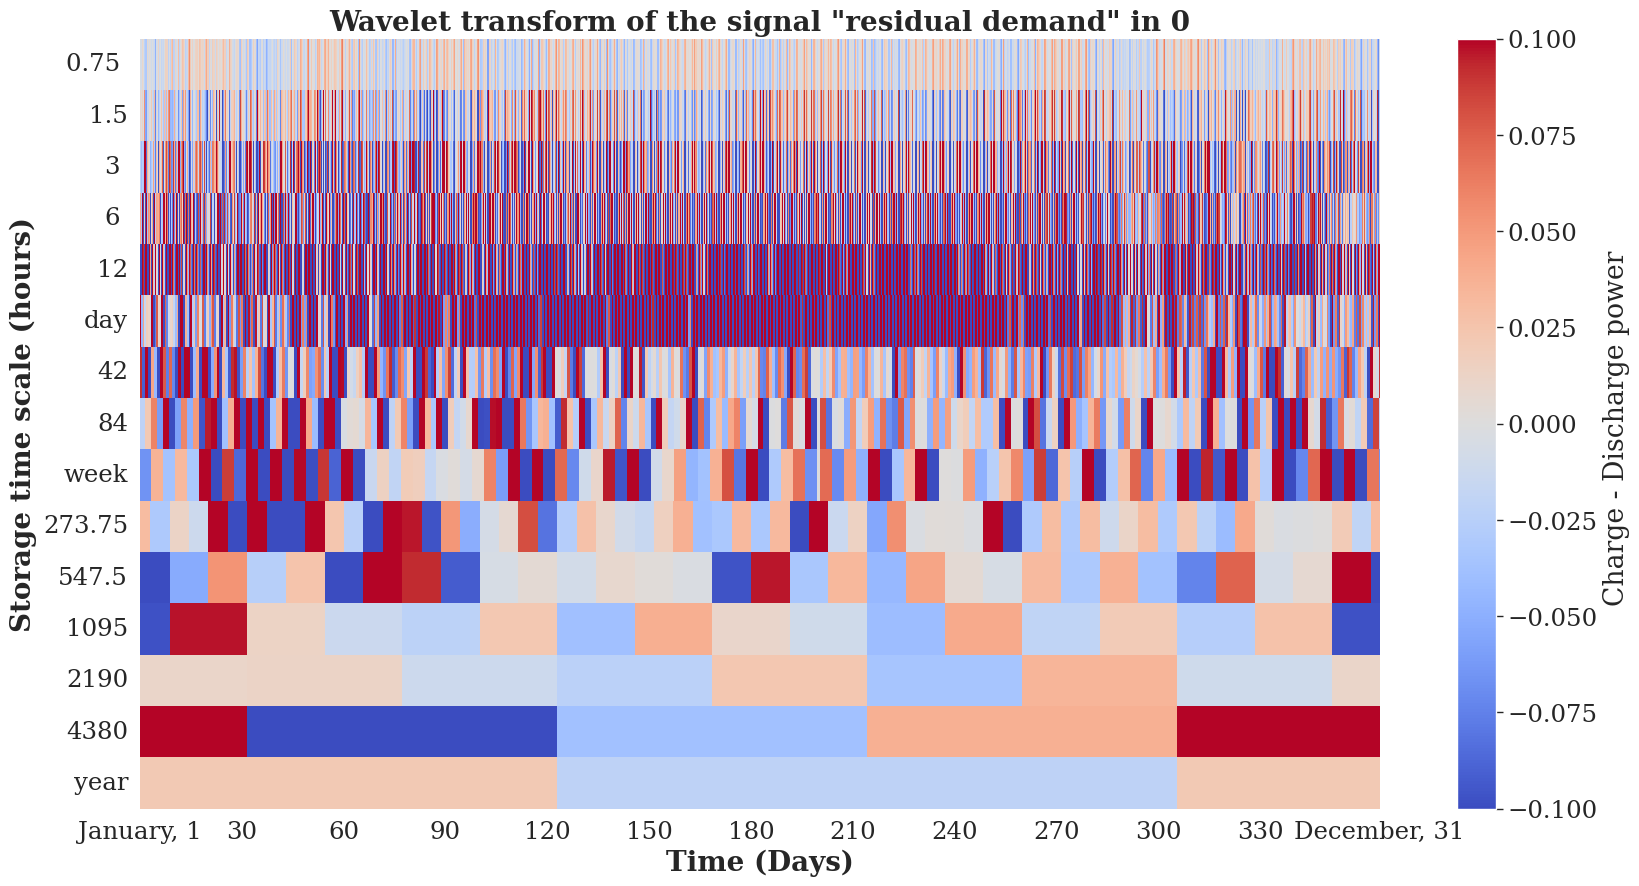

In [11]:
list_of_keys = list(per_year_betas.keys())
print(list_of_keys)

# First, select the year that must be plotted
year = list_of_keys[0]
years = list_of_keys
print("Selected Year for heatmap plot:", year)
print("Total number of year:", list_of_keys)

name = 'residual demand' # Name printed in the heatmap title

# The directory where the matrix is saved. In this case, we are using square matric
# Replace square by sine for the sine wavelet decomposition
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)

df = preplotprocessing(vy, vw , vd, ndpd, dpy, 
                      year, years,
                      time_scales,
                      per_year_betas, # Here is the datasheet you want to plot. This datasheet is returned by the function compute_betas(). Here is ploted the square decomposition
                      matrix)

plot_betas_heatmap(df, name , year , ndpd,
                      cmin= -0.1,
                      cmax= 0.1,
                    ccenter = None)

# Computing Energy, Power, and Nb of Cycles
<br/>

### From the coefficients betas of the wavelet decomposition, we can determine the flexibility required by the energy system

<br/>

***Satisfaction rate:*** Percentage of the time the consumption is satisfied. Examples:
* If satisfaction rate = 90%: At the day scales 0.9*365=328 days per year, the energy demand will be satisfied. We get rid of the 365-328=37 days with the highest electricity consumption
* Here the signal last 7 years. With a 90% satisfaction rate we get rid of the 37*7 extreme days over the last 7 years

Calculations are made on a 1 years dataset


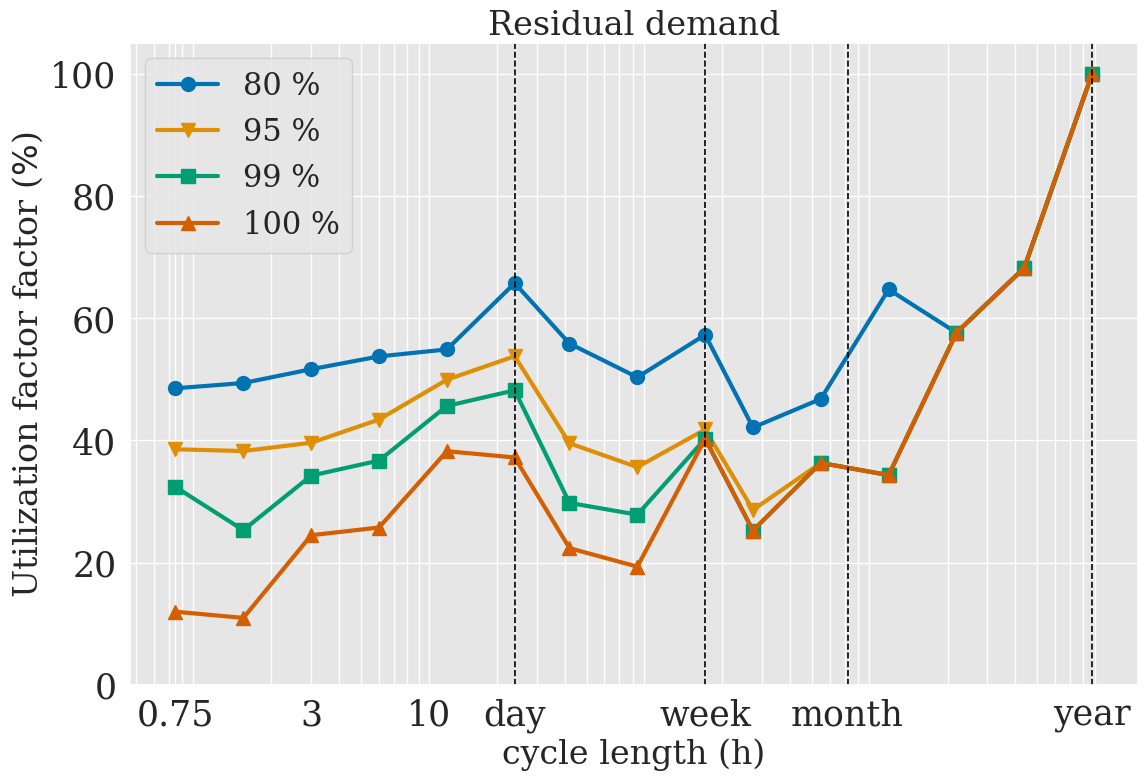

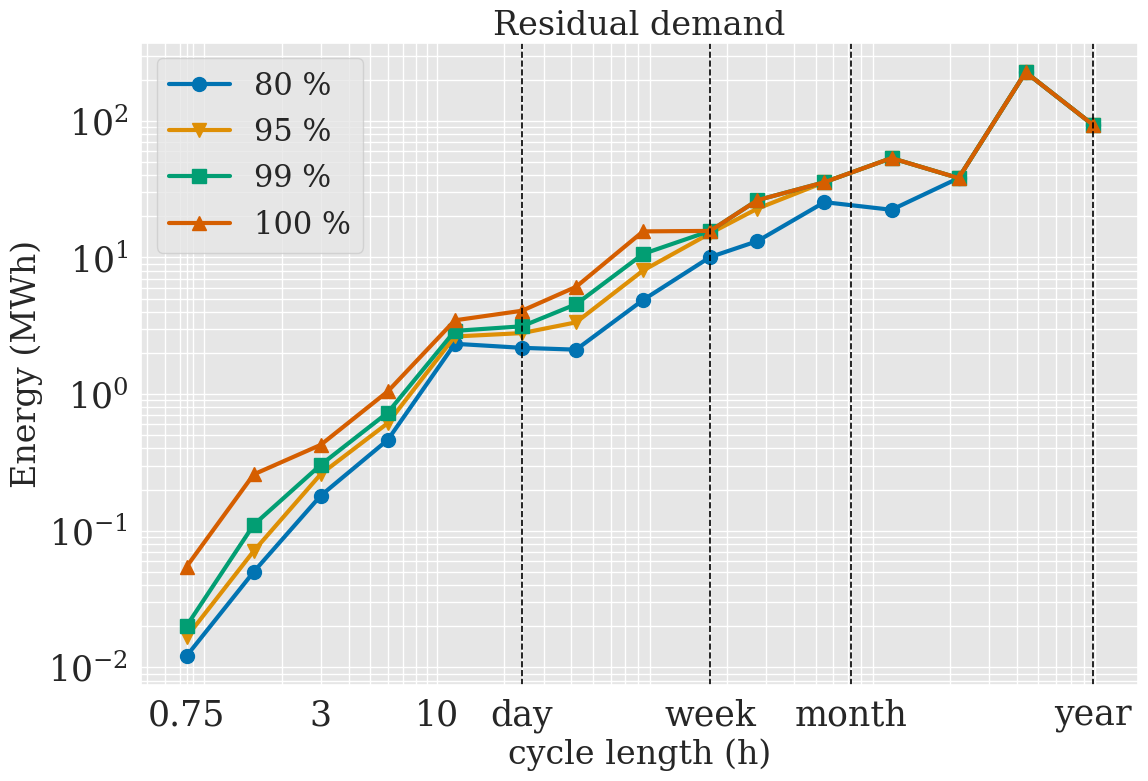

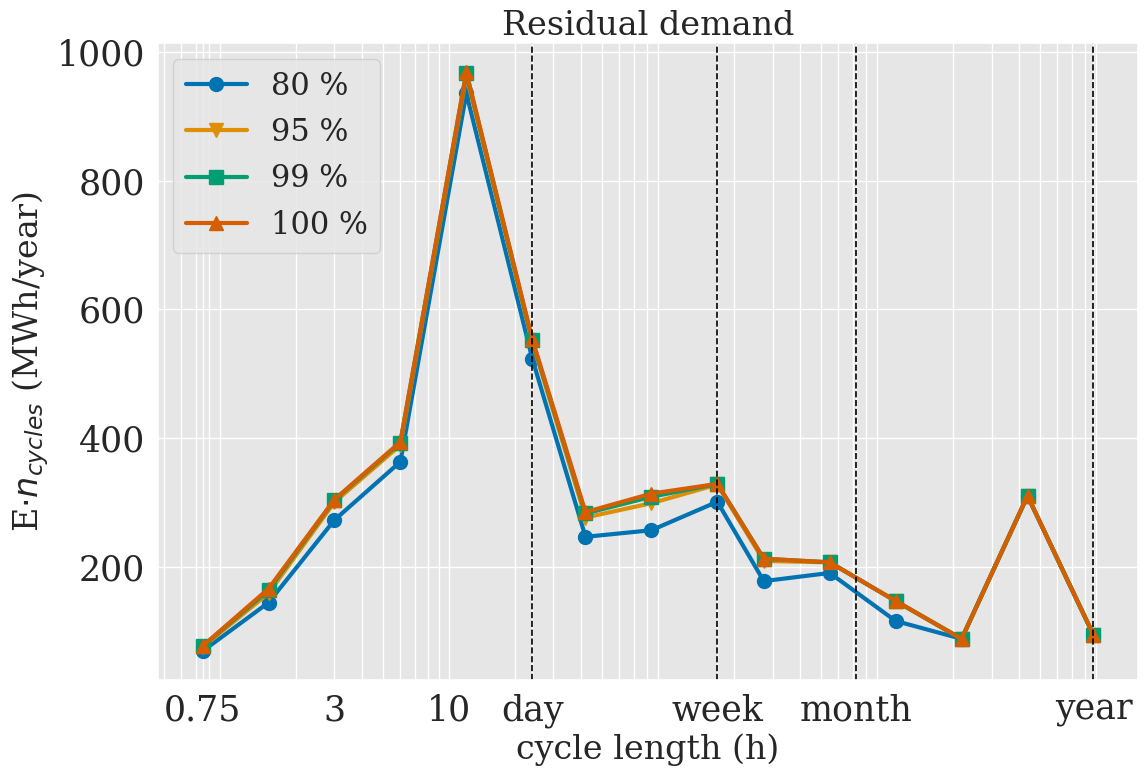

: 

In [12]:

scenario_name = 'Residual demand'
load_factor = 1.


satisfactions = [80,95,99,100] # Satisfaction rate
# Percentage of the time the load will be met by the storage device.

satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results = calc_epn(stacked_betas, satisfactions, time_scales, dpy, load_factor, shape = 'square')
plot_EPN(results['emax'], results['pmax'], results['n'], results['uf'], results['serv'],
         time_scales, satisfactions, scenario_name )